<h1 style="font-family: loraserif; font-size: 14px; color: #2e1e3b; text-align: right; ">Created By: Jieru He</h1>


<h1 style="font-family: loraserif; padding: 12px; font-size: 48px; color: #273e47; text-align: center"><b>Scrapping S&P500 ESG Risk Ratings Scores</b><br><span style="color: #ff781f; font-size: 25px">Collect Financial Data with Python</span></h1>
<hr>

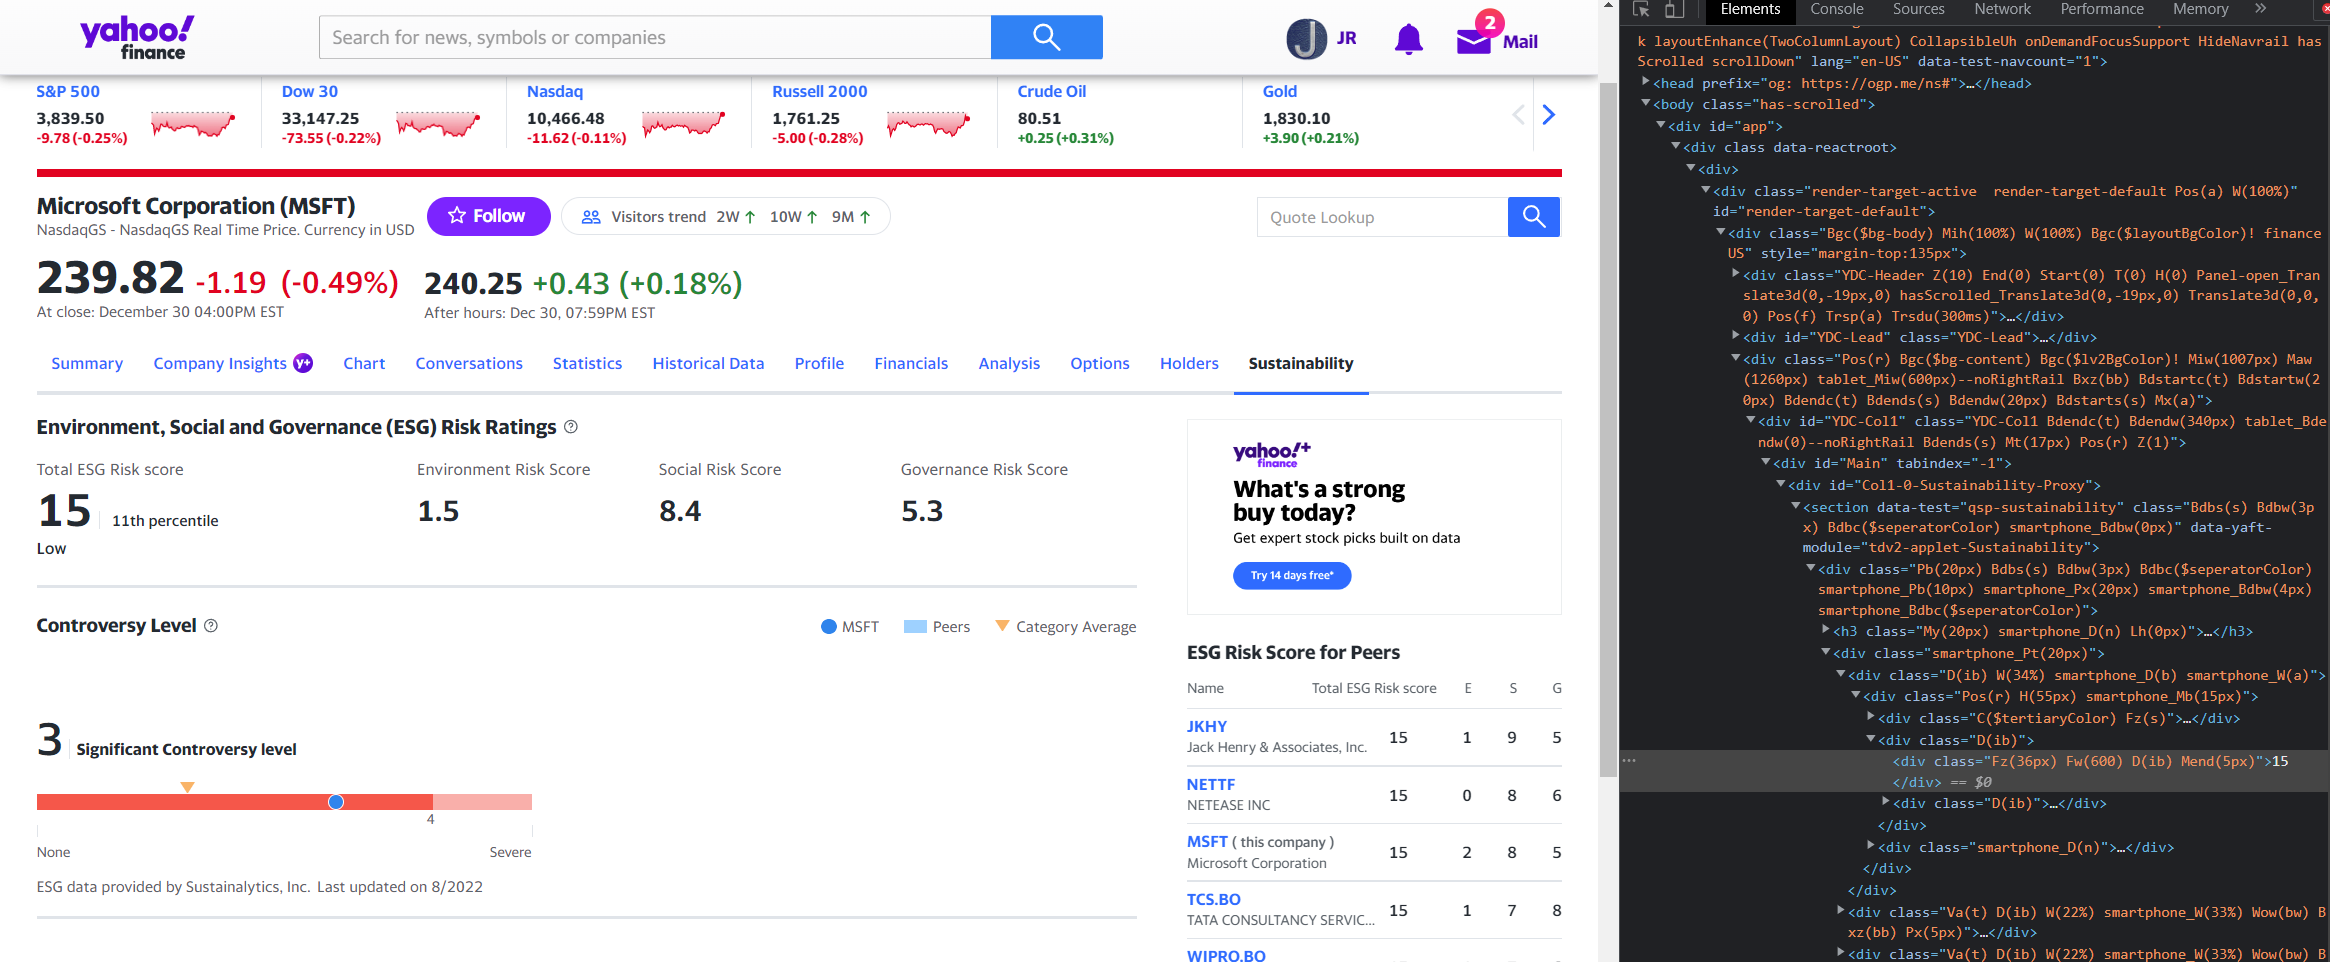

In this notebook, I scrapped ESG data from Yahoo Finance to identify how sustainable companies are. To ensure the data quality, I found that the scores on the website is from Sustainalytics' ESG Risk Ratings. The rating employs a two-dimensional framework that combines an assessment of a company's exposure to industry-specific material ESG issues with an assessment of how well the company is managing those issues.

The ultimate objective of this project is to allow users to easily toggle through companies in the S&P 500 to see their ESG scores as well as create a full dataset for further analysis.

In [78]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import ipywidgets as widgets
from ipywidgets import interact

import warnings
warnings.filterwarnings('ignore')

In [79]:
wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
sp_data=pd.read_html(wiki_page)
ticker_df=sp_data[0]
ticker_options=ticker_df['Symbol']

In [80]:
ticker_options[0]

'MMM'

In [81]:
ticker_options.shape

(503,)

In [85]:
def get_tickers():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data=pd.read_html(wiki_page)
    ticker_df=sp_data[0]
    ticker_options=ticker_df['Symbol']
    return ticker_options

In [86]:
def level(x):
    if x==0.0:
        return 'No Controversy'
    elif x==1.0:
        return 'Little Controversy'
    elif x==2.0:
        return 'Moderate Controversy'
    elif x==3.0:
        return 'Relatively High Controversy'
    else:
        return 'Severe Controversy'

In [87]:
def web_scraper(ticker):
    elements = []
    headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36","Accept-Language":"en-US,en;q=0.9"}
    web_data = requests.get('https://finance.yahoo.com/quote/'+ticker+'/sustainability?p='+ticker, headers=headers).text
    soup=BeautifulSoup(web_data, "html.parser")
    esg_score = soup.find('div', class_='Fz(36px) Fw(600) D(ib) Mend(5px)')
    datapoint = esg_score.text
    controversy_score = soup.find('div', class_='D(ib) Fz(36px) Fw(500)')
    controversy_datapoint = controversy_score.text
    scores = soup.find_all('div', class_='D(ib) Fz(23px) smartphone_Fz(22px) Fw(600)')
    for score in scores:
        elements.append(score.text)

    df=pd.DataFrame({'Total ESG Score':datapoint,
                     'Environmental Score':elements[0],
                     'Social Score':elements[1],
                     'Governance Score':elements[2],
                     'Controversy Score':controversy_datapoint}, index=[ticker])
    df=df.astype('float')
    df['Controversy Assessment']=df.apply(lambda x: level(x['Controversy Score']),axis=1)
    return df

In [88]:
@interact
def get_esg(ticker=widgets.Dropdown(descption='Ticker', options=get_tickers(),value='F')):
    esg_data=web_scraper(ticker)
    return esg_data

interactive(children=(Dropdown(description='ticker', index=204, options=('MMM', 'AOS', 'ABT', 'ABBV', 'ACN', '…

In [89]:
new_df=web_scraper(ticker_options[0])

In [90]:
new_df

,Total ESG Score,Environmental Score,Social Score,Governance Score,Controversy Score,Controversy Assessment
MMM,34.0,12.0,14.0,8.0,3.0,Relatively High Controversy


In [91]:
new_df2=web_scraper(ticker_options[1])

In [92]:
new_df2

,Total ESG Score,Environmental Score,Social Score,Governance Score,Controversy Score,Controversy Assessment
AOS,24.0,7.0,11.0,6.0,0.0,No Controversy


In [93]:
df2=pd.DataFrame()

In [94]:
pd.concat([new_df,new_df2])

,Total ESG Score,Environmental Score,Social Score,Governance Score,Controversy Score,Controversy Assessment
MMM,34.0,12.0,14.0,8.0,3.0,Relatively High Controversy
AOS,24.0,7.0,11.0,6.0,0.0,No Controversy


In [95]:
cand=pd.DataFrame()
for n in range(3):
    cand=cand.append(web_scraper(ticker_options[n]))

In [96]:
cand

,Total ESG Score,Environmental Score,Social Score,Governance Score,Controversy Score,Controversy Assessment
MMM,34.0,12.0,14.0,8.0,3.0,Relatively High Controversy
AOS,24.0,7.0,11.0,6.0,0.0,No Controversy
ABT,25.0,3.0,14.0,8.0,3.0,Relatively High Controversy


In [97]:
cand.to_excel("S&P-ESG.xlsx",encoding='utf8', index=True)

In [98]:
candall=pd.DataFrame()
for n in range(503):
    try:
        candall=candall.append(web_scraper(ticker_options[n]))
    except:
        pass

In [100]:
candall.to_excel("S&P-ESG-2.xlsx",encoding='utf8', index=True)